###### Выполнил: Завьялов Иван Викторович
###### Дата: 10.09.2025

# Разработка A/B-тестирования и анализ результатов

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Аналитика просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных


- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Задача
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных


In [1]:
# Импортируем бибилиотеку pandas
import pandas as pd

In [2]:
# Сохраняем в датафрейм исторические данные о сессиях пользователей
sessions_history_df=pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

In [3]:
# Выводим на экран первые 5 строк
display(sessions_history_df.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [4]:
# Выводим на экран общую информацию о датафрейме
sessions_history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


##### Всего в данных 435924 строки. Пропусков нет ни в одном из столбцов. Столбцы с датами нужно привести к верному типу.

#### 1.2. Знакомство с данными




In [5]:
# Рассчитываем количество уникальных сессий для каждого пользователя и выводим информацию на экран
unique_session_per_user_df=sessions_history_df.groupby('user_id')['session_id'].nunique().sort_values(ascending=False)
display(unique_session_per_user_df)

user_id
10E0DEFC1ABDBBE0    10
6A73CB5566BB494D    10
8A60431A825D035B     9
D11541BAC141FB94     9
5BCFE7C4DCC148E9     9
                    ..
1DF13BB1953B3497     1
628502A3CE7E0A3C     1
1DEEF40DEFBD0C65     1
AC08479B7472C628     1
8A0882B6715D9EE5     1
Name: session_id, Length: 134039, dtype: int64

In [6]:
# Выведем всю информацию из таблицы по первому пользователю с наибольшим количеством сессий
display(sessions_history_df[sessions_history_df['user_id']=='10E0DEFC1ABDBBE0'])

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


##### Пользователь с самым большим числом уникальных сессий является незарегистрированным и пользуется устройством Android . Установил приложение 2025-08-14 и за 12 дней провел 10 сессий. За сессию просматривал от 1 до 4 страниц.

#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.


In [7]:
# Загружаем библиотеку для визуализации
import matplotlib.pyplot as plt

In [8]:
# Приведем столбцы с датами в датафрейме к верному типу
for column in ['session_date','session_start_ts','install_date']:
    sessions_history_df[column]=pd.to_datetime(sessions_history_df[column])
    

In [9]:
# Проверяем изменения
sessions_history_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            435924 non-null  object        
 1   session_id         435924 non-null  object        
 2   session_date       435924 non-null  datetime64[ns]
 3   session_start_ts   435924 non-null  datetime64[ns]
 4   install_date       435924 non-null  datetime64[ns]
 5   session_number     435924 non-null  int64         
 6   registration_flag  435924 non-null  int64         
 7   page_counter       435924 non-null  int64         
 8   region             435924 non-null  object        
 9   device             435924 non-null  object        
dtypes: datetime64[ns](3), int64(3), object(4)
memory usage: 33.3+ MB


In [10]:
# Рассчитаем общее количество уникальных пользователей по дням
total_users_df=sessions_history_df.groupby('session_date')['user_id'].nunique()

In [11]:
# Отфильтруем датафрейм по зарегистрированным пользователям
reg_users_df=sessions_history_df[sessions_history_df['registration_flag']==1]

In [12]:
# Рассчитаем общее количество зарегистрированных пользователей по дням
reg_users_df=reg_users_df.groupby('session_date')['user_id'].nunique()

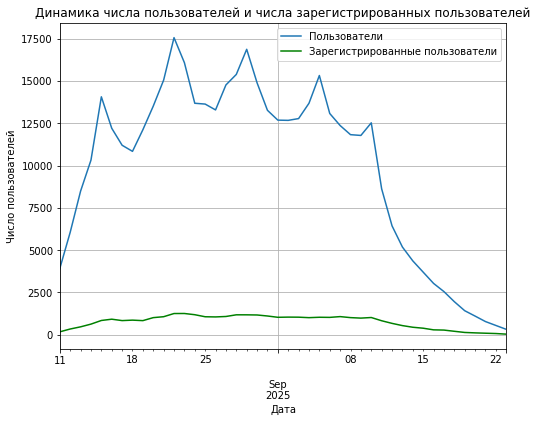

In [13]:
# Строим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням
plt.figure(figsize=(8,6))
total_users_df.plot(kind='line',label='Пользователи')
reg_users_df.plot(kind='line',color='green',label='Зарегистрированные пользователи')
plt.title('Динамика числа пользователей и числа зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Число пользователей')
plt.grid()
plt.legend()
plt.show()

##### Общее число пользователей и число зарегистрированных пользователей растёт до 22 августа, а после начинает снижаться. Особенно сильный спад наблюдается после 11 сентября.

In [14]:
# Объединим два датафрейма по дате и посчитаем долю зарегистрированных пользователей от общего числа
merged_df=total_users_df.reset_index().merge(reg_users_df,on='session_date',how='inner')
merged_df['percent']=round(merged_df['user_id_y']/merged_df['user_id_x'],4)
display(merged_df.head())

,session_date,user_id_x,user_id_y,percent
0,2025-08-11,3919,169,0.0431
1,2025-08-12,6056,336,0.0555
2,2025-08-13,8489,464,0.0547
3,2025-08-14,10321,625,0.0606
4,2025-08-15,14065,840,0.0597


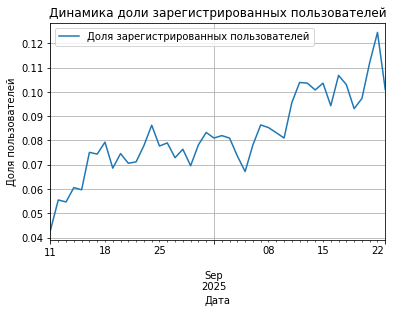

In [15]:
# Построим линейный график доли зарегистрированных пользователей от общего числа
merged_df.plot(kind='line',x='session_date',y='percent',label='Доля зарегистрированных пользователей')
plt.title('Динамика доли зарегистрированных пользователей')
plt.xlabel('Дата')
plt.ylabel('Доля пользователей')
plt.grid()
plt.legend()
plt.show()


##### Доля зарегистрированных пользователей показывает положительную динамику в течении всего периода

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.


In [16]:
# Найдём количество уникальных сессий для каждого значения просмотренных страниц
sessions_count_per_pages_df=sessions_history_df.groupby('page_counter')['session_id'].nunique().sort_values(ascending=False)
display(sessions_count_per_pages_df.head())

page_counter
3    166690
4    105569
2    105536
1     29160
5     26288
Name: session_id, dtype: int64

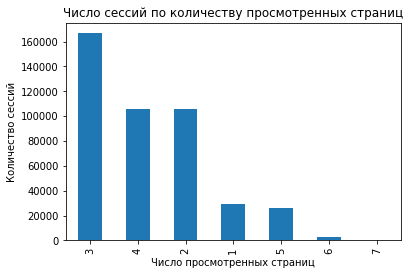

In [17]:
# Построим столбчатую диаграмму
sessions_count_per_pages_df.plot(kind='bar')
plt.title('Число сессий по количеству просмотренных страниц')
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.show()

##### Три страницы было просмотрено в самом большом количестве сессий. Меньше всего сессий было с просмотром 6 и 7 страниц.

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.


In [18]:
# Создадим новый столбец good_session
def page_counter (pages):
    if pages>=4:
        return 1
    else:
        return 0
        
sessions_history_df['good_session']=sessions_history_df['page_counter'].apply(page_counter)
display(sessions_history_df.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


In [19]:
# Найдём долю успешных сессий от всех сессий
good_session_df=sessions_history_df.groupby('session_date').agg({'session_id':'count',
                                                        'good_session':'sum'}).reset_index()
good_session_df['percent']=round((good_session_df['good_session']/good_session_df['session_id']),3)
display(good_session_df.head())


,session_date,session_id,good_session,percent
0,2025-08-11,3919,1226,0.313
1,2025-08-12,6056,1829,0.302
2,2025-08-13,8489,2604,0.307
3,2025-08-14,10321,3262,0.316
4,2025-08-15,14065,4289,0.305


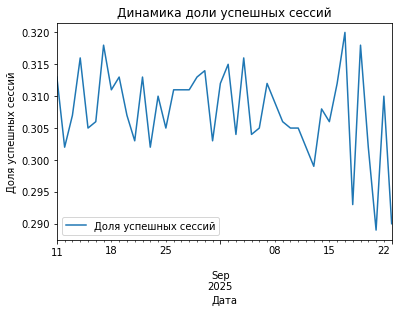

In [20]:
# Построим график доли успешных сессий
good_session_df.plot(kind='line',x='session_date',y='percent',label='Доля успешных сессий')
plt.title('Динамика доли успешных сессий')
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий')
plt.show()

##### Доля успешных сессий с количеством просмотренных страниц более 4 стабильна до 8 сентября. После 8 сентября метрика нестабильна и прослеживается динамика на снижение доли успешных сессий.

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез


##### Перед проведением A/B теста выберем ключевую метрику и сформулируем нулевую и альтернативную гипотезы:
   ###### Команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Так как продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций, то эту метрику стоит выбрать ключевой для A/B теста.
   ###### Сформулируем нулевую и альтернативную гипотезы:
- H0: при внедрении нового алгоритма рекомендаций доля успешных сессий, с количеством просмотренных страниц 4 и более, не изменится
- H1: при внедрении нового алгоритма рекомендаций доля успешных сессий, с количеством просмотренных страниц 4 и более, увеличится

#### 2.2. Расчёт размера выборки


In [21]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 1-beta  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = (1+0.03)*p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p,mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста


In [22]:
from math import ceil

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users =round(total_users_df.mean())

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907 пользователей в день составит 9 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей


In [23]:
# Сохраняем в датафрейм исторические данные о сессиях пользователей
sessions_test_part_df=pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')

In [24]:
# Познакомимся с данными и выведем первые 5 строк датафрейма
display(sessions_test_part_df.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [25]:
# Выведем всю информацию о датафрейме
sessions_test_part_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            3130 non-null   object
 1   session_id         3130 non-null   object
 2   session_date       3130 non-null   object
 3   session_start_ts   3130 non-null   object
 4   install_date       3130 non-null   object
 5   session_number     3130 non-null   int64 
 6   registration_flag  3130 non-null   int64 
 7   page_counter       3130 non-null   int64 
 8   region             3130 non-null   object
 9   device             3130 non-null   object
 10  test_group         3130 non-null   object
dtypes: int64(3), object(8)
memory usage: 269.1+ KB


##### Всего в таблице 3130 строк. Пропусков нет. Столбцы с датой нужно привести к верному типу.

In [26]:
# Приведем столбцы с датами в датафрейме к верному типу
for column in ['session_date','session_start_ts','install_date']:
    sessions_test_part_df[column]=pd.to_datetime(sessions_test_part_df[column])

In [27]:
# Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения
test_grouped_df=sessions_test_part_df.groupby(['session_date','test_group'])['user_id'].nunique().sort_values(ascending=False).reset_index()
display(test_grouped_df)

,session_date,test_group,user_id
0,2025-10-14,A,1477
1,2025-10-14,B,1466


In [28]:
# Выведем число пользователей в каждой группе
group_list=test_grouped_df['user_id'].tolist()
A_group_count=group_list[0]
B_group_count=group_list[1]

In [29]:
# Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B
P=100*((A_group_count-B_group_count)/A_group_count)
print( f" Разница в количестве пользователей в группах А и В составляет: {P:.2f}% ")

 Разница в количестве пользователей в группах А и В составляет: 0.74% 


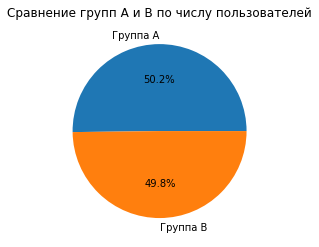

In [30]:
# Построим визуализацию для сравнения двух групп пользователей
groups=[A_group_count,B_group_count]
plt.pie(groups,
        labels=['Группа А','Группа B'],
        autopct='%1.1f%%')
plt.title('Сравнение групп А и В по числу пользователей')
plt.show()

#### 3.2. Проверка пересечений пользователей


In [31]:
# Отфильтруем пользователей по группам
group_a=sessions_test_part_df[sessions_test_part_df['test_group']=='A']['user_id'].tolist()
group_b=sessions_test_part_df[sessions_test_part_df['test_group']=='B']['user_id'].tolist()

In [32]:
# Найдем пересечения списков пользователей
common_users=list(set(group_a) & set(group_b))
print(f"Общее число пользователей в группах А и В: {len(common_users)}")                

Общее число пользователей в группах А и В: 0


#### 3.3. Равномерность разделения пользователей по устройствам



In [33]:
# Сгруппируем данные по устройствам для группы А
devices_A=sessions_test_part_df[sessions_test_part_df['test_group']=='A'].groupby('device')['user_id'].nunique()

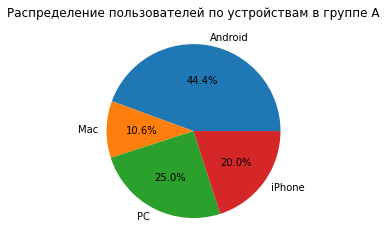

In [34]:
# Построими круговую диаграмму
plt.pie(devices_A,labels=devices_A.index,autopct='%1.1f%%')
plt.title('Распределение пользователей по устройствам в группе А')
plt.show()

In [35]:
# Сгруппируем данные по устройствам для группы B
devices_B=sessions_test_part_df[sessions_test_part_df['test_group']=='B'].groupby('device')['user_id'].nunique()

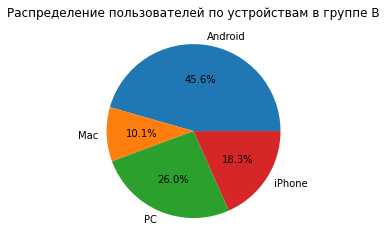

In [36]:
# Построими круговую диаграмму
plt.pie(devices_B,labels=devices_B.index,autopct='%1.1f%%')
plt.title('Распределение пользователей по устройствам в группе B')
plt.show()

#### 3.4. Равномерность распределения пользователей по регионам



In [37]:
# Сгруппируем данные по регионам для группы А
regions_A=sessions_test_part_df[sessions_test_part_df['test_group']=='A'].groupby('region')['user_id'].nunique().sort_values(ascending=False).reset_index()

In [38]:
# Посчитаем долю каждого региона
regions_A['user_id']=round(regions_A['user_id']/regions_A['user_id'].sum()*100,1)
display(regions_A)

,region,user_id
0,CIS,43.6
1,MENA,41.2
2,EU,15.2


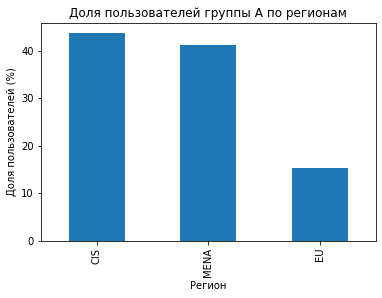

In [39]:
# Построим столбчатую диаграмму
regions_A.plot(kind='bar',x='region',ylabel='Доля пользователей (%)',xlabel='Регион',legend=False)
plt.title('Доля пользователей группы А по регионам')
plt.show()

In [40]:
# Сгруппируем данные по регионам для группы B
regions_B=sessions_test_part_df[sessions_test_part_df['test_group']=='B'].groupby('region')['user_id'].nunique().sort_values(ascending=False).reset_index()

In [41]:
# Посчитаем долю каждого региона
regions_B['user_id']=round(regions_B['user_id']/regions_B['user_id'].sum()*100,1)
display(regions_B)

,region,user_id
0,CIS,44.0
1,MENA,41.2
2,EU,14.8


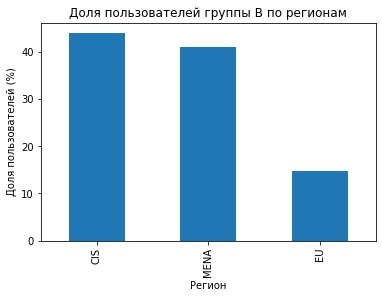

In [42]:
# Построим столбчатую диаграмму
regions_B.plot(kind='bar',x='region',ylabel='Доля пользователей (%)',xlabel='Регион',legend=False)
plt.title('Доля пользователей группы B по регионам')
plt.show()

##### На этапе мониторинга A/B теста было выявлено следующее:
- разница в количестве пользователей двух групп составляет 0.74%, что является допустимым для корректности проведения тестирования и анализа дальнейших результатов
- выборки являются независимыми, так как не было обнаружено пересечения по пользователям для двух групп
- также равномерное распределение пользователей сохраняется для двух групп в зависимости от категориальных переменных, таких как регион и используемое устройство

##### Можно сделать вывод, что А/В тест проходит корректно и каких-либо нарушений не наблюдается

### 4. Проверка результатов A/B-теста


#### 4.1. Получение результатов теста и подсчёт основной метрики


In [43]:
# Сохраняем в датафрейм исторические данные о сессиях пользователей
sessions_test_df=pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')

In [44]:
# Выведем первые пять строк
display(sessions_test_df.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B


In [45]:
# Выведем информацию о датафрейме
sessions_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100005 entries, 0 to 100004
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            100005 non-null  object
 1   session_id         100005 non-null  object
 2   session_date       100005 non-null  object
 3   session_start_ts   100005 non-null  object
 4   install_date       100005 non-null  object
 5   session_number     100005 non-null  int64 
 6   registration_flag  100005 non-null  int64 
 7   page_counter       100005 non-null  int64 
 8   region             100005 non-null  object
 9   device             100005 non-null  object
 10  test_group         100005 non-null  object
dtypes: int64(3), object(8)
memory usage: 8.4+ MB


##### Всего в датафрейме 100005 строк. Пропусков нет. Столбцы с датой нужно привести к верному типу.

In [46]:
# Приведем столбцы с датами в датафрейме к верному типу
for column in ['session_date','session_start_ts','install_date']:
    sessions_test_df[column]=pd.to_datetime(sessions_test_df[column])

In [47]:
# Создадим новый столбец good_session
def page_counter (pages):
    if pages>=4:
        return 1
    else:
        return 0
        
sessions_test_df['good_session']=sessions_test_df['page_counter'].apply(page_counter)
display(sessions_test_df.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста



In [48]:
# Рассчитаем количество уникальных сессий для обеих тестовых групп
grouped_sessions_df=sessions_test_df.groupby(['session_date','test_group'])['session_id'].nunique().unstack()
display(grouped_sessions_df.head())

test_group,A,B
session_date,,
2025-10-14,1502,1628
2025-10-15,2235,2283
2025-10-16,3280,3241
2025-10-17,4089,4054
2025-10-18,5013,5059


##### Сформулируем нулевую и альтернативную гипотезы для статиститического теста:
- Н0: количество уникальных дневных сессий в двух выборках не различается или различия не статиститически значимы
- Н1: количество уникальных дневных сессий в двух выборках  различается и различия статистически значимы


##### Для сравнения двух выборок используем t-test для проверки гипотезы о равенстве средних двух выборок с помощью метода ttest_ind(). Уровень статистической значимости alpha выберем равным 0.05.

In [49]:
# Проведем статистический тест
from scipy import stats as st
group_A=grouped_sessions_df['A']
group_B=grouped_sessions_df['B']
alpha=0.05
result=st.ttest_ind(group_A,group_B,alternative='two-sided')
print('p-значение:',result.pvalue)
if result.pvalue<alpha:
    print('Отвергаем нулевую гипотезу.Количество уникальных дневных сессий в двух выборках различается и различия статистически значимы')
else:
    print('Не получилось отвергнуть нулевую гипотезу. Количество уникальных дневных сессий в двух выборках не различается или различия не статиститически значимы ')

p-значение: 0.938219304859116
Не получилось отвергнуть нулевую гипотезу. Количество уникальных дневных сессий в двух выборках не различается или различия не статиститически значимы 


#### 4.3. Сравнение доли успешных сессий



In [50]:
# Рассчитаем общее количество сессий и успешных сессий для обеих групп
group_good_session_df=sessions_test_df.groupby('test_group')['good_session'].agg(['count','sum']).reset_index()
display(group_good_session_df)

,test_group,count,sum
0,A,49551,15248
1,B,50454,16059


In [51]:
# Рассчитаем долю успешных сессий для каждой группы
group_good_session_df['part']=round(group_good_session_df['sum']/group_good_session_df['count'],4)
display(group_good_session_df)

,test_group,count,sum,part
0,A,49551,15248,0.3077
1,B,50454,16059,0.3183


In [52]:
# Найдём разницу между долями успешных сессий в двух группах
list=group_good_session_df['part'].tolist()
difference_A_B=round(list[1]-list[0],4)
print(f" Доля успешных сессий в группе А составляет: {list[0]}, а в группе В:{list[1]} ")
print(f" Разница между группами B и A составляет: {difference_A_B} ")

 Доля успешных сессий в группе А составляет: 0.3077, а в группе В:0.3183 
 Разница между группами B и A составляет: 0.0106 


#### 4.4. Насколько статистически значимо изменение ключевой метрики



##### Для сравнения долей в двух выборках используем Z-test пропорций.

In [53]:
# Подготовим данные о количестве успехов и размерах выборок
count_list=group_good_session_df['count'].tolist()
success_list=group_good_session_df['sum'].tolist()
n_a,n_b=count_list[0],count_list[1]
m_a,m_b=success_list[0],success_list[1]

In [55]:
# Проводим Z-test пропорций, уровень значимости alpha установим равным 0.05
from statsmodels.stats.proportion import proportions_ztest

alpha=0.05

stat_ztest,p_value_ztest=proportions_ztest([m_b, m_a],
    [n_b, n_a],
    alternative='larger')
print(f"Полученное значение p-value:{p_value_ztest}")
if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! При внедрении нового алгоритма рекомендаций доля успешных сессий, с количеством просмотренных страниц 4 и более, не изменится или изменения не статистически значимы')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! При внедрении нового алгоритма рекомендаций доля успешных сессий, с количеством просмотренных страниц 4 и более, увеличится и увеличение статистически значимо')

Полученное значение p-value:0.0001574739988036123
pvalue=0.0001574739988036123 < 0.05
Нулевая гипотеза не находит подтверждения! При внедрении нового алгоритма рекомендаций доля успешных сессий, с количеством просмотренных страниц 4 и более, увеличится и увеличение статистически значимо


#### 4.5. Вывод по результатам A/B-эксперимента



###### Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Для проведения A/B-теста, который позволил проверить эту гипотезу, было зайдействовано 82080 пользователей и длительность эксперимента составила 20 дней. Ключевой метрикой была выбрана доля успешных сессий с количеством просмотренных страниц более 4
- во время проведения эксперимента группы были проверены на равенство размеров выборок, непересечение пользователей и равномерность распределения пользователей по устройствам и регионам, что позволяет считать, что А/В тест проходил корректно
- по результатам теста было определено следующее: при внедрении нового алгоритма рекомендаций доля успешных сессий в тестовой группе была выше на 1.06% чем в контрольной группе
- при статистическом анализе с помощью Z-теста пропорций было найдено значение p-value равное 0.0001574739988036123, что меньше установленного уровня статистической значимости, равного 0.05. Это говорит о том,что прирост ключевой метрики статистически значим и не является случайностью
- по результатам эксперимента можно сделать вывод, что  новый алгоритм рекомендаций увеличивает долю успешных сессий и целесообразно рассмотреть вопрос о его внедрении